In [1]:
pip install fuzzy-c-means

# Importing Modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, Birch, MiniBatchKMeans
from sklearn.metrics import homogeneity_score, rand_score, v_measure_score

from scipy.stats import multivariate_normal

from fcmeans import FCM

# Importing Dataset

In [3]:
df = pd.read_csv('covtype_train.zip')

In [4]:
df.head()

,Elevation,Aspect,Slope,Hillshade_9am,Hillshade_Noon,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Fire_Points,Soil_Type,Wilderness,target
0,elevation_medium,aspect_medium,slope_low,hillshade_9am_max,hillnoon_max,0,1,low,22,0,2
1,elevation_high,aspect_medium,slope_low,hillshade_9am_max,hillnoon_max,1,1,mid,32,2,1
2,elevation_medium,aspect_low,slope_low,hillshade_9am_max,hillnoon_max,1,1,low,10,2,2
3,elevation_high,aspect_ultra,slope_medium,hillshade_9am_max,hillnoon_max,2,1,low,23,2,1
4,elevation_high,aspect_high,slope_low,hillshade_9am_max,hillnoon_max,2,1,mid,28,0,2


# Encoding Categorical Values

In [5]:
df = pd.get_dummies(df) 

In [6]:
df.head()

,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Soil_Type,Wilderness,target,Elevation_elevation_high,Elevation_elevation_low,Elevation_elevation_medium,Elevation_elevation_ultra,Aspect_aspect_high,Aspect_aspect_low,Aspect_aspect_medium,Aspect_aspect_ultra,Slope_slope_high,Slope_slope_low,Slope_slope_medium,Slope_slope_ultra,Hillshade_9am_hillshade_9am_max,Hillshade_9am_hillshade_9am_min,Hillshade_Noon_hillnoon_max,Hillshade_Noon_hillnoon_min,Horizontal_Distance_To_Fire_Points_high,Horizontal_Distance_To_Fire_Points_low,Horizontal_Distance_To_Fire_Points_mid
0,0,1,22,0,2,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0
1,1,1,32,2,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1
2,1,1,10,2,2,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0
3,2,1,23,2,1,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0
4,2,1,28,0,2,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1


# Spliting into X and y values

In [7]:
y = df['target']
X = df.drop(columns=['target'])

# Clustering

In [8]:
n_clusters = 7

## PCA

In [9]:
pca = PCA(n_components=3,random_state=0)
df_pca = pd.DataFrame(pca.fit_transform(X))

In [10]:
print("Cumulative Variance with 3PCs ",np.cumsum(pca.explained_variance_ratio_))

Cumulative Variance with 3PCs  [0.95393967 0.96739897 0.97804271]


## Functions

In [11]:
def plot_2d(labels):
  fig, axis = plt.subplots()
  sc = axis.scatter(df_pca.iloc[:,0],df_pca.iloc[:,1],c=labels)
  axis.legend(*sc.legend_elements(), title='clusters',loc=4)
  plt.show()

In [12]:
def plot_3d(labels):
  fig = plt.figure(figsize=(15,15))
  ax = fig.add_subplot(111,projection='3d')
  for label in range(1,8):
    ax.scatter(df_pca.iloc[labels == label,0],df_pca.iloc[labels == label,1],df_pca.iloc[labels == label,2], s = 40 , cmap='viridis', label = "cluster "+str(label))

  ax.legend()
  plt.show()

In [13]:
def compare_true_and_predicted(y_pred):
  cluster_len_y = np.bincount(y)[1:]
  cluster_len_y_pred = np.bincount(y_pred)[1:]
  
  prop_y  = cluster_len_y/len(y)
  prop_y_pred = cluster_len_y_pred/len(y)

  print("V-measure score",v_measure_score(y,y_pred))
  print("Homogeneity score",homogeneity_score(y,y_pred))
  print("Rand score",rand_score(y,y_pred))

  print("\nTrue Label Counts\n",cluster_len_y)
  print("Cluster Distribution\n",cluster_len_y_pred)

  
  print("\n\nProportion of points in each cluster:\n")
  print("For True Labels\n",prop_y)
  print("For predicted\n",prop_y_pred)

  print("\n\nCluster Representation compared to true labels:\n")
  for i in range(len(cluster_len_y)):
    representation_percentage = (prop_y_pred[i] - prop_y[i])*100
    if representation_percentage>0:
      print("Cluster",(i+1),"is overrepresented by",representation_percentage,"%")
    elif representation_percentage<0:
      print("Cluster",(i+1),"is underrepresented by",representation_percentage,"%")

## 1 Gaussian Based

In [14]:
gaussian = GaussianMixture(n_components=n_clusters,random_state=0).fit(df_pca)
labels = gaussian.predict(df_pca) + 1

### 1.1 Representative Objects and Centroids

In [15]:
print("Means\n",gaussian.means_)
print("\n\nCovariances\n",gaussian.covariances_)

Means
 [[-14.33048854   0.32707579  -0.07316152]
 [ 12.72648744   0.10057065   0.05330428]
 [ -4.853531     0.11161925   1.50922941]
 [ -4.89035321  -1.10293942   0.23471094]
 [  1.71058991  -0.33009248   0.06795308]
 [ 20.80973755   0.6794516   -0.43413735]
 [ -7.82036662   0.91755591  -0.58787067]]


Covariances
 [[[ 1.06737761e+00 -2.49459955e-01 -1.32449487e-01]
  [-2.49459955e-01  1.69810563e+00  5.43643594e-01]
  [-1.32449487e-01  5.43643594e-01  1.06058787e+00]]

 [[ 3.09910153e+00  4.97610217e-01 -3.68684921e-01]
  [ 4.97610217e-01  1.10888940e+00 -3.41826175e-01]
  [-3.68684921e-01 -3.41826175e-01  1.37541045e+00]]

 [[ 1.23198617e-01 -2.43556996e-02  1.05088708e-03]
  [-2.43556996e-02  2.99353959e-01  2.52288624e-01]
  [ 1.05088708e-03  2.52288624e-01  3.23418712e-01]]

 [[ 1.71585194e-01 -2.46634685e-03  2.02766619e-02]
  [-2.46634685e-03  1.50033564e-01  1.14968838e-01]
  [ 2.02766619e-02  1.14968838e-01  1.80005716e-01]]

 [[ 2.21029216e+00 -5.80270252e-01  2.38559064e-01]

In [16]:
centers = np.zeros((7,3))

for i in range(7):
  random_variable = multivariate_normal(mean = gaussian.means_[i],cov=gaussian.covariances_[i])
  density = random_variable.logpdf(df_pca)
  centers[i] = df_pca.iloc[np.argmax(density)]

centers

array([[-1.46436462e+01,  5.07037585e-01,  1.05055270e-01],
       [ 1.34027414e+01,  2.24116943e-01, -1.94197900e-01],
       [-4.71319310e+00,  9.74704334e-02,  1.57581317e+00],
       [-4.67130192e+00, -1.23842545e+00,  1.92657373e-01],
       [ 1.34104970e+00, -2.53641898e-01,  1.97510349e-02],
       [ 2.04192990e+01,  1.07782557e+00, -4.13110364e-01],
       [-7.62647943e+00,  8.73596533e-01, -5.98146787e-01]])

### 1.2 Visualize Clusters

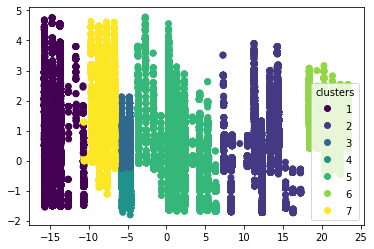

In [17]:
plot_2d(labels)

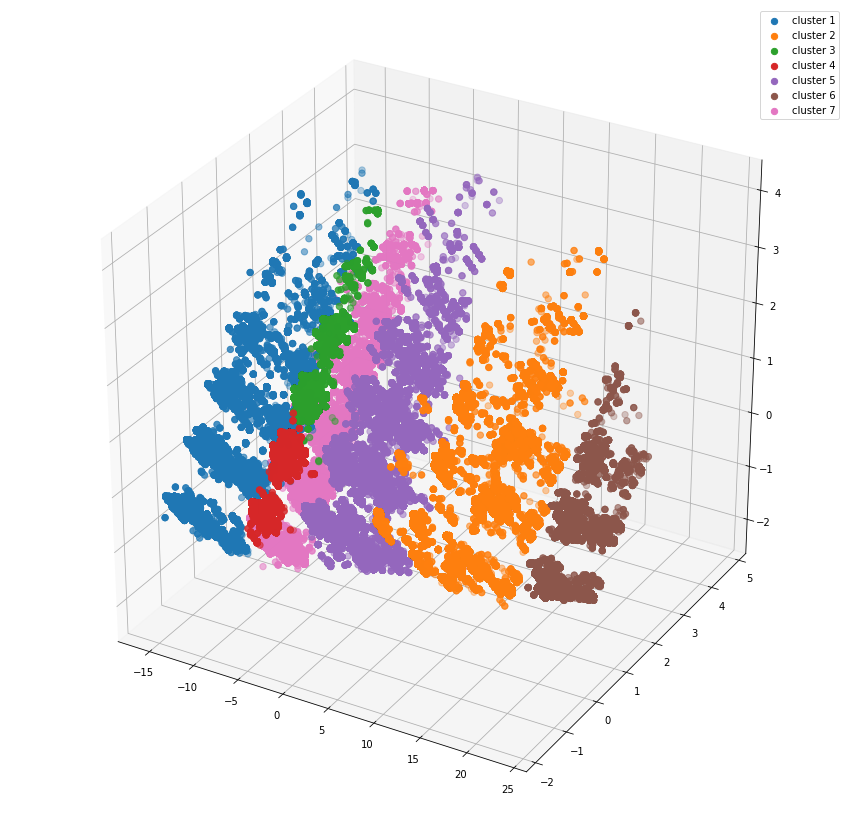

In [18]:
plot_3d(labels)

### 1.3 Comparing Cluster Distribution With True Label Counts

In [19]:
compare_true_and_predicted(labels)

V-measure score 0.214883344611975
Homogeneity score 0.26828591642345473
Rand score 0.6177580731034045

True Label Counts
 [148288 198310  25028   1923   6645  12157  14357]
Cluster Distribution
 [27815 70583 21525 80059 93730 25130 87866]


Proportion of points in each cluster:

For True Labels
 [0.36460556 0.48759798 0.06153801 0.00472821 0.0163385  0.02989122
 0.03530051]
For predicted
 [0.06839059 0.17354711 0.05292495 0.19684639 0.23046018 0.0617888
 0.21604198]


Cluster Representation compared to true labels:

Cluster 1 is underrepresented by -29.62149748714065 %
Cluster 2 is underrepresented by -31.4050866961063 %
Cluster 3 is underrepresented by -0.8613059000560592 %
Cluster 4 is overrepresented by 19.21181781523845 %
Cluster 5 is overrepresented by 21.41216794358606 %
Cluster 6 is overrepresented by 3.1897577623257964 %
Cluster 7 is overrepresented by 18.0741465621527 %


## 2 K-Means

In [20]:
kmeans = KMeans(n_clusters=n_clusters,random_state=0).fit(df_pca)
labels = kmeans.predict(df_pca) + 1

### 2.1 Cluster Centers

In [21]:
kmeans.cluster_centers_

array([[ -4.85704434,  -0.78323496,   0.52653102],
       [ 13.04557621,   0.13417694,   0.08398096],
       [-14.44753369,   0.34015623,  -0.08795273],
       [ -7.84855395,   0.90799137,  -0.57849004],
       [  5.72335799,  -0.75290146,   0.16244481],
       [ 20.79081282,   0.67814001,  -0.42823241],
       [  1.39076703,  -0.28967763,   0.02725263]])

### 2.2 Visualize Clusters

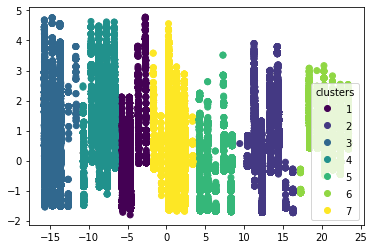

In [22]:
plot_2d(labels)

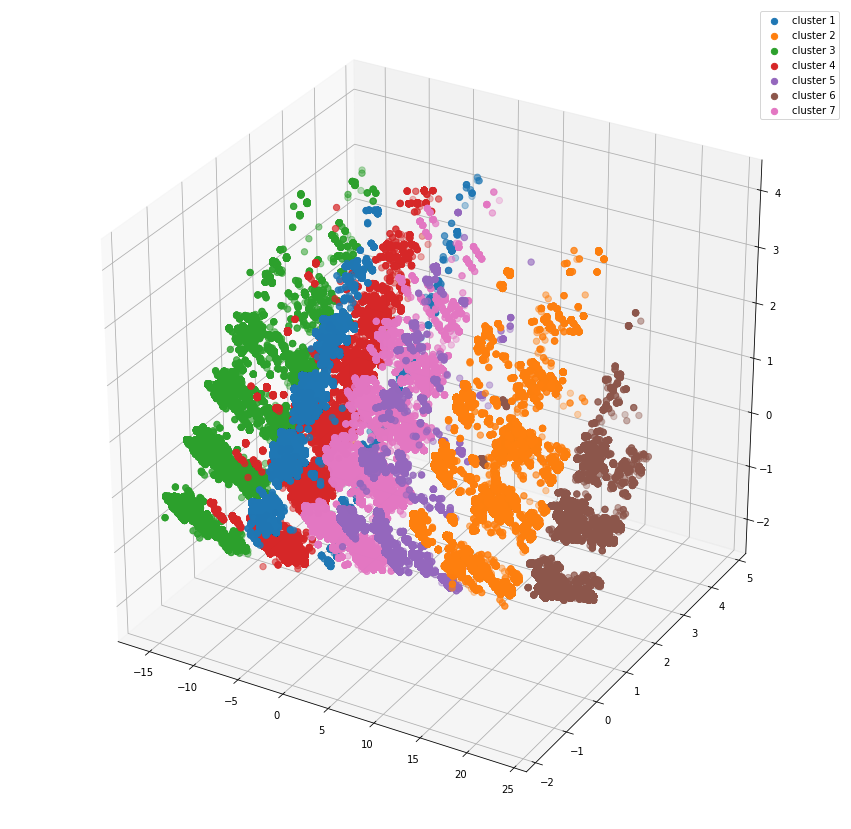

In [23]:
plot_3d(labels)

### 2.3 Comparing Cluster Distribution With True Label Counts

In [24]:
compare_true_and_predicted(labels)

V-measure score 0.2160347498535246
Homogeneity score 0.26682307273516237
Rand score 0.6208212467310872

True Label Counts
 [148288 198310  25028   1923   6645  12157  14357]
Cluster Distribution
 [103022  66133  26981  88681  15026  25198  81667]


Proportion of points in each cluster:

For True Labels
 [0.36460556 0.48759798 0.06153801 0.00472821 0.0163385  0.02989122
 0.03530051]
For predicted
 [0.25330704 0.1626056  0.06633998 0.21804587 0.03694543 0.061956
 0.20080008]


Cluster Representation compared to true labels:

Cluster 1 is underrepresented by -11.129852375660182 %
Cluster 2 is underrepresented by -32.499237782389336 %
Cluster 3 is overrepresented by 0.4801970947215205 %
Cluster 4 is overrepresented by 21.331766279492907 %
Cluster 5 is overrepresented by 2.060692191941147 %
Cluster 6 is overrepresented by 3.2064773744307953 %
Cluster 7 is overrepresented by 16.54995721746314 %


## 3 Birch

In [25]:
birch = Birch(n_clusters=n_clusters).fit(df_pca)
labels = birch.predict(df_pca) + 1

### 3.1 Centroids of all subclusters

In [26]:
birch.subcluster_centers_

array([[-8.60575644e+00,  8.93153498e-01, -9.45134739e-01],
       [-7.61685913e+00,  6.96234312e-01, -7.87398069e-01],
       [-8.63400347e+00,  1.64459415e+00, -1.74678322e-01],
       [-8.57967048e+00,  8.43248048e-02, -1.67090950e+00],
       [-7.63892563e+00,  1.41608768e+00, -4.72607193e-02],
       [-6.61568093e+00,  6.96323415e-01, -7.66488991e-01],
       [-7.59469078e+00,  1.46412031e-02, -1.51050788e+00],
       [-7.66025497e+00,  2.14264764e+00,  6.95544613e-01],
       [-1.04406347e+01,  5.00522371e-02, -1.64908536e+00],
       [-6.58610286e+00,  9.85070420e-03, -1.51834960e+00],
       [-8.66679864e+00,  7.29340649e-01,  4.49410527e-01],
       [-9.60568759e+00,  8.29131883e-01, -9.47387788e-01],
       [-6.68763124e+00,  2.98785852e+00,  1.44793040e+00],
       [-7.71863457e+00,  3.56031268e+00,  2.46188701e+00],
       [-8.65908616e+00,  2.30607011e+00,  5.71891841e-01],
       [-7.65062794e+00, -7.79932779e-02, -1.03405527e-01],
       [-8.70295475e+00,  3.67712685e+00

### 3.2 Visualize Clusters

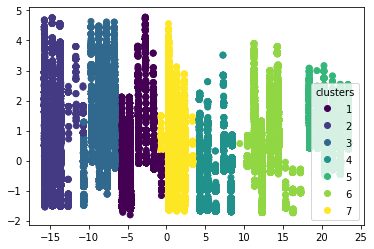

In [27]:
plot_2d(labels)

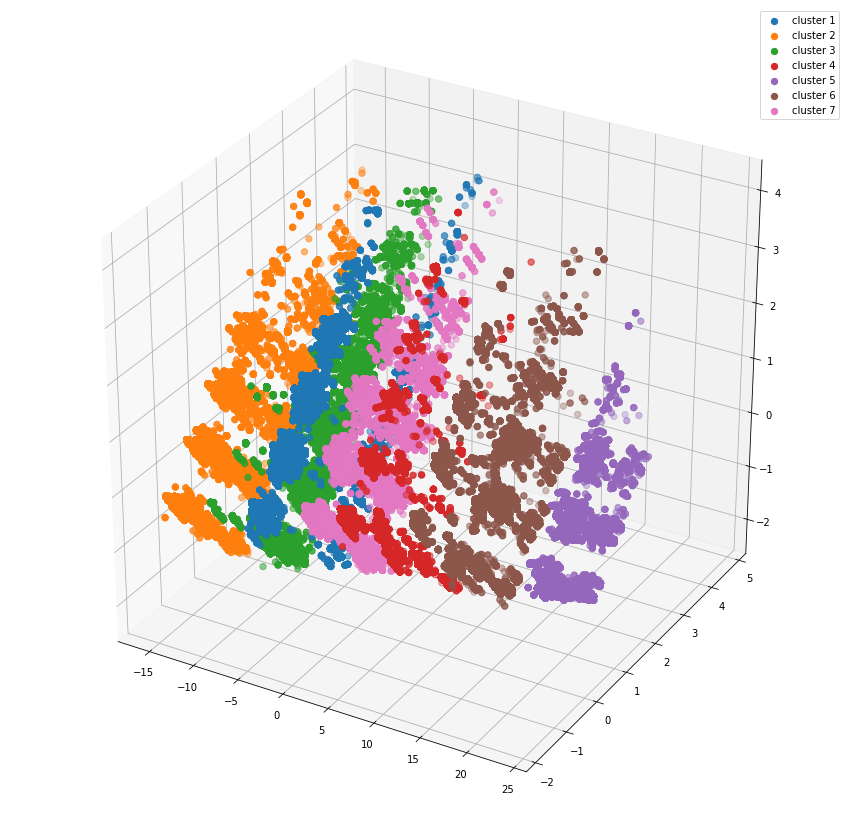

In [28]:
plot_3d(labels)

### 3.3 Comparing Cluster Distribution With True Label Counts

In [29]:
compare_true_and_predicted(labels)

V-measure score 0.21838163229718102
Homogeneity score 0.26964003125463565
Rand score 0.6218413875175778

True Label Counts
 [148288 198310  25028   1923   6645  12157  14357]
Cluster Distribution
 [105004  27152  88510  15026  25130  66201  79685]


Proportion of points in each cluster:

For True Labels
 [0.36460556 0.48759798 0.06153801 0.00472821 0.0163385  0.02989122
 0.03530051]
For predicted
 [0.25818032 0.06676043 0.21762542 0.03694543 0.0617888  0.1627728
 0.19592681]


Cluster Representation compared to true labels:

Cluster 1 is underrepresented by -10.642524858129176 %
Cluster 2 is underrepresented by -42.08375542158011 %
Cluster 3 is overrepresented by 15.608741406611133 %
Cluster 4 is overrepresented by 3.221721726644177 %
Cluster 5 is overrepresented by 4.54502984942514 %
Cluster 6 is overrepresented by 13.288157597096689 %
Cluster 7 is overrepresented by 16.06262969993214 %


## 4 Mini Batch K Means

In [30]:
miniBatchKMeans = MiniBatchKMeans(n_clusters=n_clusters,random_state=0).fit(df_pca)
labels = miniBatchKMeans.predict(df_pca)+1

### 4.1 Cluster Centers

In [31]:
miniBatchKMeans.cluster_centers_

array([[  5.82123639,  -0.82152819,   0.18063948],
       [ -4.85627731,  -0.7543809 ,   0.5478819 ],
       [ 20.66437034,   0.67813789,  -0.44754259],
       [-14.41002785,   0.43195749,  -0.07359517],
       [  1.38746098,  -0.29566984,   0.0380987 ],
       [ -7.82845518,   0.90318514,  -0.57438691],
       [ 13.10106239,   0.14729236,   0.03780597]])

### 4.2 Visualize Clusters

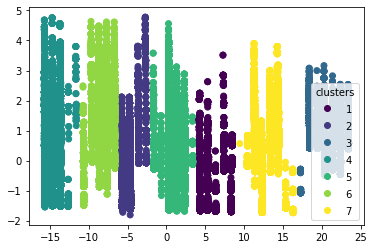

In [32]:
plot_2d(labels)

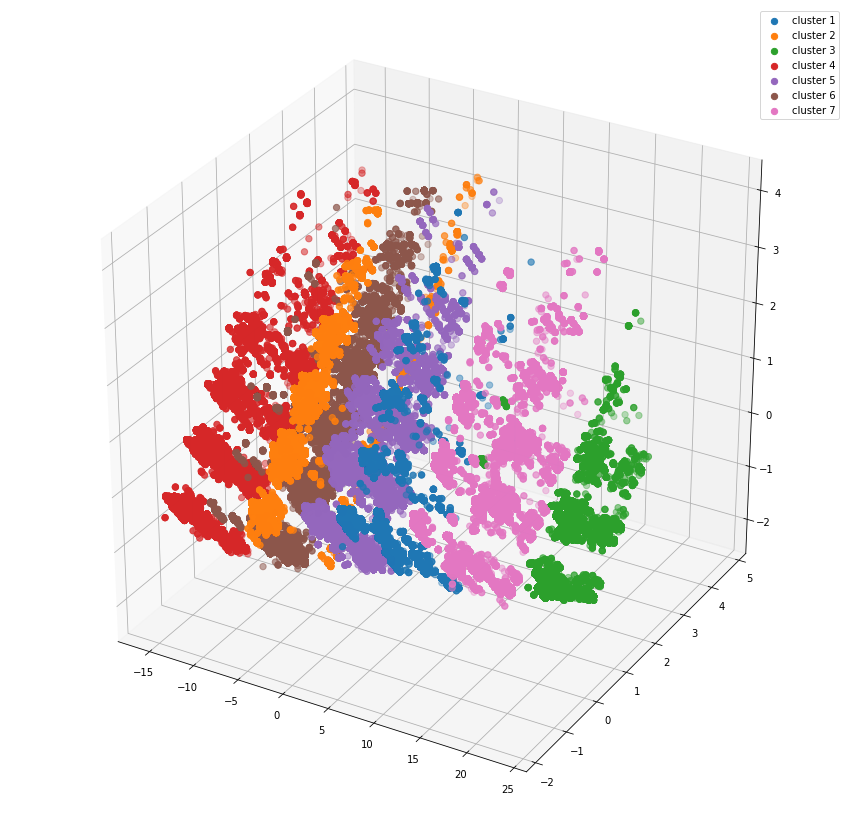

In [33]:
plot_3d(labels)

### 4.3 Comparing Cluster Distribution With True Label Counts

In [34]:
compare_true_and_predicted(labels)

V-measure score 0.2160347498535246
Homogeneity score 0.26682307273516237
Rand score 0.6208212467310872

True Label Counts
 [148288 198310  25028   1923   6645  12157  14357]
Cluster Distribution
 [ 15026 103022  25198  26981  81667  88681  66133]


Proportion of points in each cluster:

For True Labels
 [0.36460556 0.48759798 0.06153801 0.00472821 0.0163385  0.02989122
 0.03530051]
For predicted
 [0.03694543 0.25330704 0.061956   0.06633998 0.20080008 0.21804587
 0.1626056 ]


Cluster Representation compared to true labels:

Cluster 1 is underrepresented by -32.76601394612351 %
Cluster 2 is underrepresented by -23.429094092075893 %
Cluster 3 is overrepresented by 0.041799030262498066 %
Cluster 4 is overrepresented by 6.161177060692192 %
Cluster 5 is overrepresented by 18.44615793148893 %
Cluster 6 is overrepresented by 18.81546465769053 %
Cluster 7 is overrepresented by 12.730509358065245 %


## 5 Fuzzy c-means

In [35]:
fcm = FCM(n_clusters=n_clusters)
fcm.fit(df_pca.to_numpy())
labels = fcm.predict(df_pca.to_numpy()) + 1

### 5.1 Cluster Centers

In [36]:
fcm.centers

array([[13.08696832,  0.09917512,  0.03113753],
       [-9.10878782,  0.79428265, -0.56016019],
       [ 0.88890452,  0.30779181, -0.57152553],
       [-5.11379085, -0.75714904,  0.38631228],
       [ 5.33765706, -0.81238817,  0.24113572],
       [ 1.55838549, -0.99320391,  0.39344789],
       [20.83252363,  0.62286175, -0.41491981]])

### 5.2 Visualize Clusters

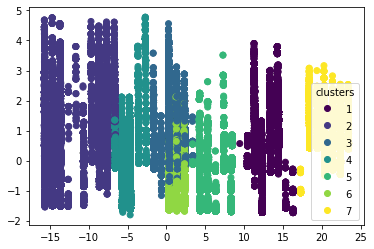

In [37]:
plot_2d(labels)

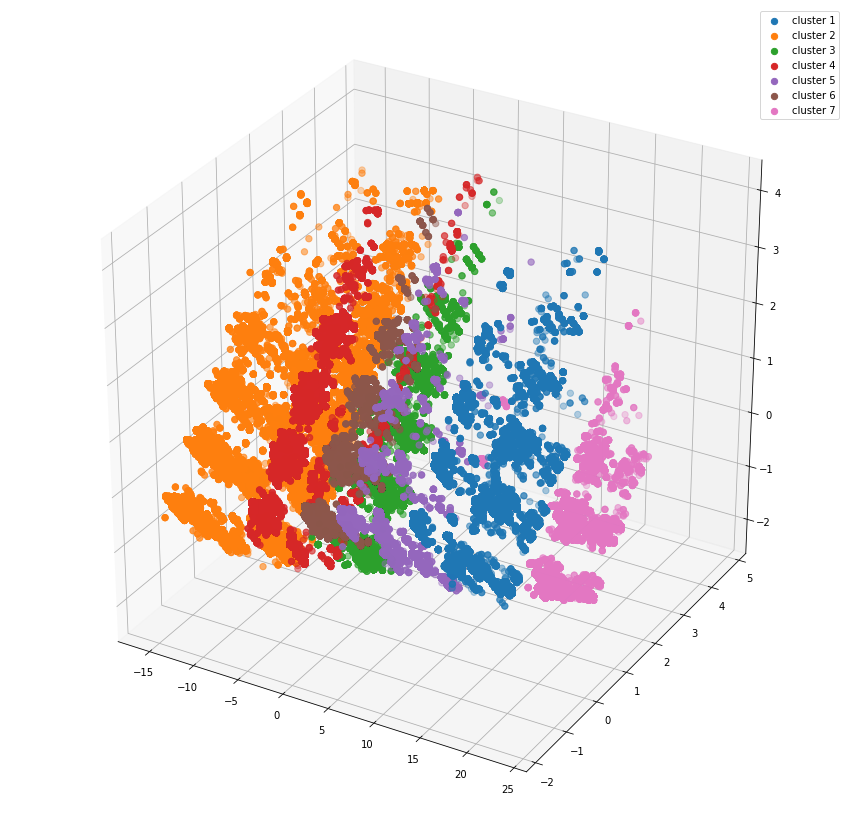

In [38]:
plot_3d(labels)

### 5.3 Comparing Cluster Distribution With True Label Counts

In [39]:
compare_true_and_predicted(labels)

V-measure score 0.1836340353612263
Homogeneity score 0.22573617342888677
Rand score 0.6082720976991959

True Label Counts
 [148288 198310  25028   1923   6645  12157  14357]
Cluster Distribution
 [ 66133 104222  38005 114462  15587  43101  25198]


Proportion of points in each cluster:

For True Labels
 [0.36460556 0.48759798 0.06153801 0.00472821 0.0163385  0.02989122
 0.03530051]
For predicted
 [0.1626056  0.25625756 0.09344542 0.28143533 0.03832479 0.10597529
 0.061956  ]


Cluster Representation compared to true labels:

Cluster 1 is underrepresented by -20.199996065973625 %
Cluster 2 is underrepresented by -23.134042113752372 %
Cluster 3 is overrepresented by 3.190741268920209 %
Cluster 4 is overrepresented by 27.67071215712501 %
Cluster 5 is overrepresented by 2.1986289918073902 %
Cluster 6 is overrepresented by 7.608407014369031 %
Cluster 7 is overrepresented by 2.6655487475043516 %
